In [1]:
import numpy as np
import cmocean
import copy
import netCDF4 as nc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmpy as ESMF
from scipy import stats
import xarray as xr
import pyart
import cmocean
experiment = "diurnal"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def get_model_ds(src_model):
    
    # CONSTRUCT FILE NAME
    ncfil = (mod_dict[src_model]['dir'] 
            + mod_dict[src_model]['fil_pre'] 
            + '_' + mod_dict[src_model]['temp_var'] 
            + '_1993-2023_' + season + '_ts.nc')

    # Construct File Path  
    print(ncfil)
            
    # Open as xarray dataset
    ds = xr.open_dataset((ncfil),decode_times=False)
            
    if src_model == 'NEP':
        ds = ds.rename({'z_l':'depth'})
    elif src_model == 'OISST':
        ds = ds.rename({'zlev':'depth'})
        
        
    return ds

In [3]:
def get_coords(src_model,ds):
 
    if src_model == 'OISST':
        lat = ds.lat.values
        lon = ds.lon.values

        clat = np.append(lat[0]-np.diff(lat)[0]/2, np.append((lat[:-1]+lat[1:])/2.,lat[-1]+np.diff(lat)[-1]/2))
        clon = np.append(lon[0]-np.diff(lon)[0]/2,np.append((lon[:-1]+lon[1:])/2.,lon[-1]+np.diff(lon)[-1]/2))

    elif src_model == 'NEP':
 
        lon = nep_lon
        lat = nep_lat
        clon = nep_clon 
        clat = nep_clat
        
    elif src_model == 'GLORYS12':
   
        lon = ds.longitude.values
        lat = ds.latitude.values
                    
        # REGULARLY SPACED LAT/LON, can extrapolate outer corner bounds
        clon = (lon[:-1] + lon[1:])/2
        clat = (lat[:-1] + lat[1:])/2            
        clon = np.insert(np.insert(clon,0,2*clon[0]-clon[1]),-1,2*clon[-1]-clon[-2])
        clat = np.insert(np.insert(clat,0,2*clat[0]-clat[1]),-1,2*clat[-1]-clat[-2])

    lons,lats = np.meshgrid(lon,lat)
    chuk_mask = lats>66
    return lat,lon,clat,clon,chuk_mask

In [4]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [5]:
def outline_nep_domain(ax,clon,clat):
    #NEP DOMAIN OUTLINE
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)

In [6]:
def plot_map(clon,clat,lon,lat,var_val,vmin,vmax,cmap,norm,c_inc):
    # create axes object
    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))
    
    # make pcolormesh with prescribed clon/clat
    C = ax.pcolormesh(clon,clat,var_val, transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm)
    
    # add contours with prescribed lon/lat
    levels = np.arange(vmin,vmax+c_inc/2,c_inc)
    CS = ax.contour(lon,lat,var_val,levels, colors='k', transform=ccrs.PlateCarree())

    # add 50m resolution land and coastlines
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',facecolor='blanchedalmond')
    ax.add_feature(land_50m,zorder=50)
    ax.coastlines('50m',zorder=50)
    
    # outline extent of NEP domain
    outline_nep_domain(ax,nep_clon,nep_clat)
            
    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([25, 55])
    
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.bottom_labels = False
    gl.top_labels = False
        
    if ncol>0:
        gl.left_labels = False
        
    if ncol<2:
        gl.right_labels = False
    
    if nrow == 4:
        gl.bottom_labels = True
        
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
    # COLORBARS
    if dep == '200m':
        pos = ax.get_position()
        if ncol == 0:
            cax = fig.add_axes([pos.x0, pos.y0-.3*pos.height, 2*pos.width, .1*pos.height])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            cbar.ax.locator_params(nbins=5)
            cax.plot([levels]*2, [0, 1], 'k')
            cbar.ax.tick_params(labelsize=16)
            cax.set_xlabel(r'Temperature ($^\circ$C)',fontsize=20)
            
        elif ncol == 3:
            cax = fig.add_axes([pos.x0, pos.y0-.3*pos.height, pos.width, .1*pos.height])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            cbar.ax.locator_params(nbins=7)
            cax.plot([levels[levels>=0]]*2, [0, 1], 'k')
            cax.plot([levels[levels<0]]*2, [0, 1], '--k')
            cbar.ax.tick_params(labelsize=16)
            cax.set_xlabel(r'Difference ($^\circ$C)',fontsize=20)
            
    # Labels
    if ncol == 0:
        plt_lab = depths[dep]['plt_lab']   
        ax.text(243.0, 56, plt_lab, transform=ccrs.PlateCarree(), fontsize=25, ha='center', zorder=53)
    elif ncol == 3:
        stats_text = 'Bias: ' + f'{mean_bias:.2f}' + '\nRMSE: ' + f'{rmse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nR: ' + f'{corr[0]:.2f}' 
        ax.text(.03, .05, stats_text, ha="left", va="bottom", size=26, bbox=stats_box_props,transform=ax.transAxes)
                
    # Titles
    if nrow <3:
        if ncol == 0:
            title_text = 'NEP10k'
        elif ncol == 1:
            title_text = comp_mod
        else:
            title_text = 'NEP10k - ' + comp_mod
        
        ax.set_title(title_text, fontsize=28)
        
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)     
    
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon),
                   np.min(nep_clat),70], crs=ccrs.PlateCarree())    

In [7]:
def calc_stats(nep_val_stats, comp_val_stats, area_val):
    # CALCULATE STATISTICS
    nan_idx = ~np.isnan(nep_val_stats)*~np.isnan(comp_val_stats)
    
    # Mean Bias
    mean_bias = np.nanmean((nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEAN BIAS:', mean_bias)

    # Mean Bias Area Weighted
    mean_bias = np.nansum(((nep_val_stats*area_val)[nan_idx]-(comp_val_stats*area_val)[nan_idx])/np.nansum(area_val[nan_idx]))
    if print_stats:
        print('AREA-WEIGHTED MEAN BIAS:', mean_bias)

    # RMSE 
    rmse = np.sqrt(np.mean(((nep_val_stats-comp_val_stats)**2)[nan_idx]))
    if print_stats:
        print('RMSE:', rmse)

    # RMSE Area weighted
    rmse = np.sqrt(np.sum((((nep_val_stats-comp_val_stats)**2)*area_val)[nan_idx]/np.sum(area_val[nan_idx])))
    if print_stats:
        print('AREA-WEIGHTED RMSE:', rmse)
        
    # Median absolute error
    medae = np.nanmedian(np.abs(nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEDIAN ABSOLUTE ERROR:', medae)

    # Correlation
    corr = stats.pearsonr(nep_val_stats[nan_idx].ravel(), comp_val_stats[nan_idx].ravel())
    if print_stats:
        print('CORRELATION:', corr)
    
    return mean_bias, rmse, medae, corr

In [8]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()


In [9]:
mod_dict = {'NEP':{'dir': f'/work/Utheri.Wagura/NEP/plotting/Figure_2/{experiment}/',
                   'fil_pre':'nep',
                   'temp_var':'thetao',
                   'plt_title':'NEP MOM6 (10km; '},
            'OISST':{'dir':'/work/role.medgrp/NEP/plotting/Figure_2/',
                     'fil_pre':'oisst',
                     'temp_var':'sst',
                     'depths':['surface'],
                     'plt_title':'OISST'},
            'GLORYS12':{'dir':'/work/role.medgrp/NEP/plotting/Figure_2/',
                      'fil_pre':'glorys',
                      'temp_var':'thetao',
                      'depths':['surface','100m','200m'],
                      'plt_title':r'GLORYS12 ($\dfrac{1}{12}^o$; '}}

# DEPTHS
depths = {'surface': {'val':2.5, 'plt_lab':'SST'}, 
          '100m':    {'val':100, 'plt_lab':'100m'},
          '200m':    {'val':200, 'plt_lab':'200m'}}

cmap1 = 'pyart_HomeyerRainbow'
bounds = np.linspace(3,28,26)
norm1 = mcolors.BoundaryNorm(bounds, 256, extend='both')

cmap2 = cmocean.cm.balance
bounds = np.linspace(-1.5,1.5,25)
norm2 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')
plot_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m']


/work/Utheri.Wagura/NEP/plotting/Figure_2/diurnal/nep_thetao_1993-2023_mean_ts.nc
OISST
/work/role.medgrp/NEP/plotting/Figure_2/oisst_sst_1993-2023_mean_ts.nc
surface
MEAN BIAS: 0.19715716296260252
AREA-WEIGHTED MEAN BIAS: 0.2045539528093664
RMSE: 0.44803706116899367
AREA-WEIGHTED RMSE: 0.44593851253957184
MEDIAN ABSOLUTE ERROR: 0.26850458461460924
CORRELATION: PearsonRResult(statistic=0.9982771073243022, pvalue=0.0)
GLORYS12
/work/role.medgrp/NEP/plotting/Figure_2/glorys_thetao_1993-2023_mean_ts.nc
surface
MEAN BIAS: 0.17113716443409158
AREA-WEIGHTED MEAN BIAS: 0.18278089142369025
RMSE: 0.3948776686028745
AREA-WEIGHTED RMSE: 0.3963688362413295
MEDIAN ABSOLUTE ERROR: 0.24800376631823795
CORRELATION: PearsonRResult(statistic=0.9987531285859481, pvalue=0.0)
100m
MEAN BIAS: 0.4548455558877919
AREA-WEIGHTED MEAN BIAS: 0.44506369323150946
RMSE: 0.5983415480802309
AREA-WEIGHTED RMSE: 0.5890446965612337
MEDIAN ABSOLUTE ERROR: 0.42063937057203393
CORRELATION: PearsonRResult(statistic=0.9978314

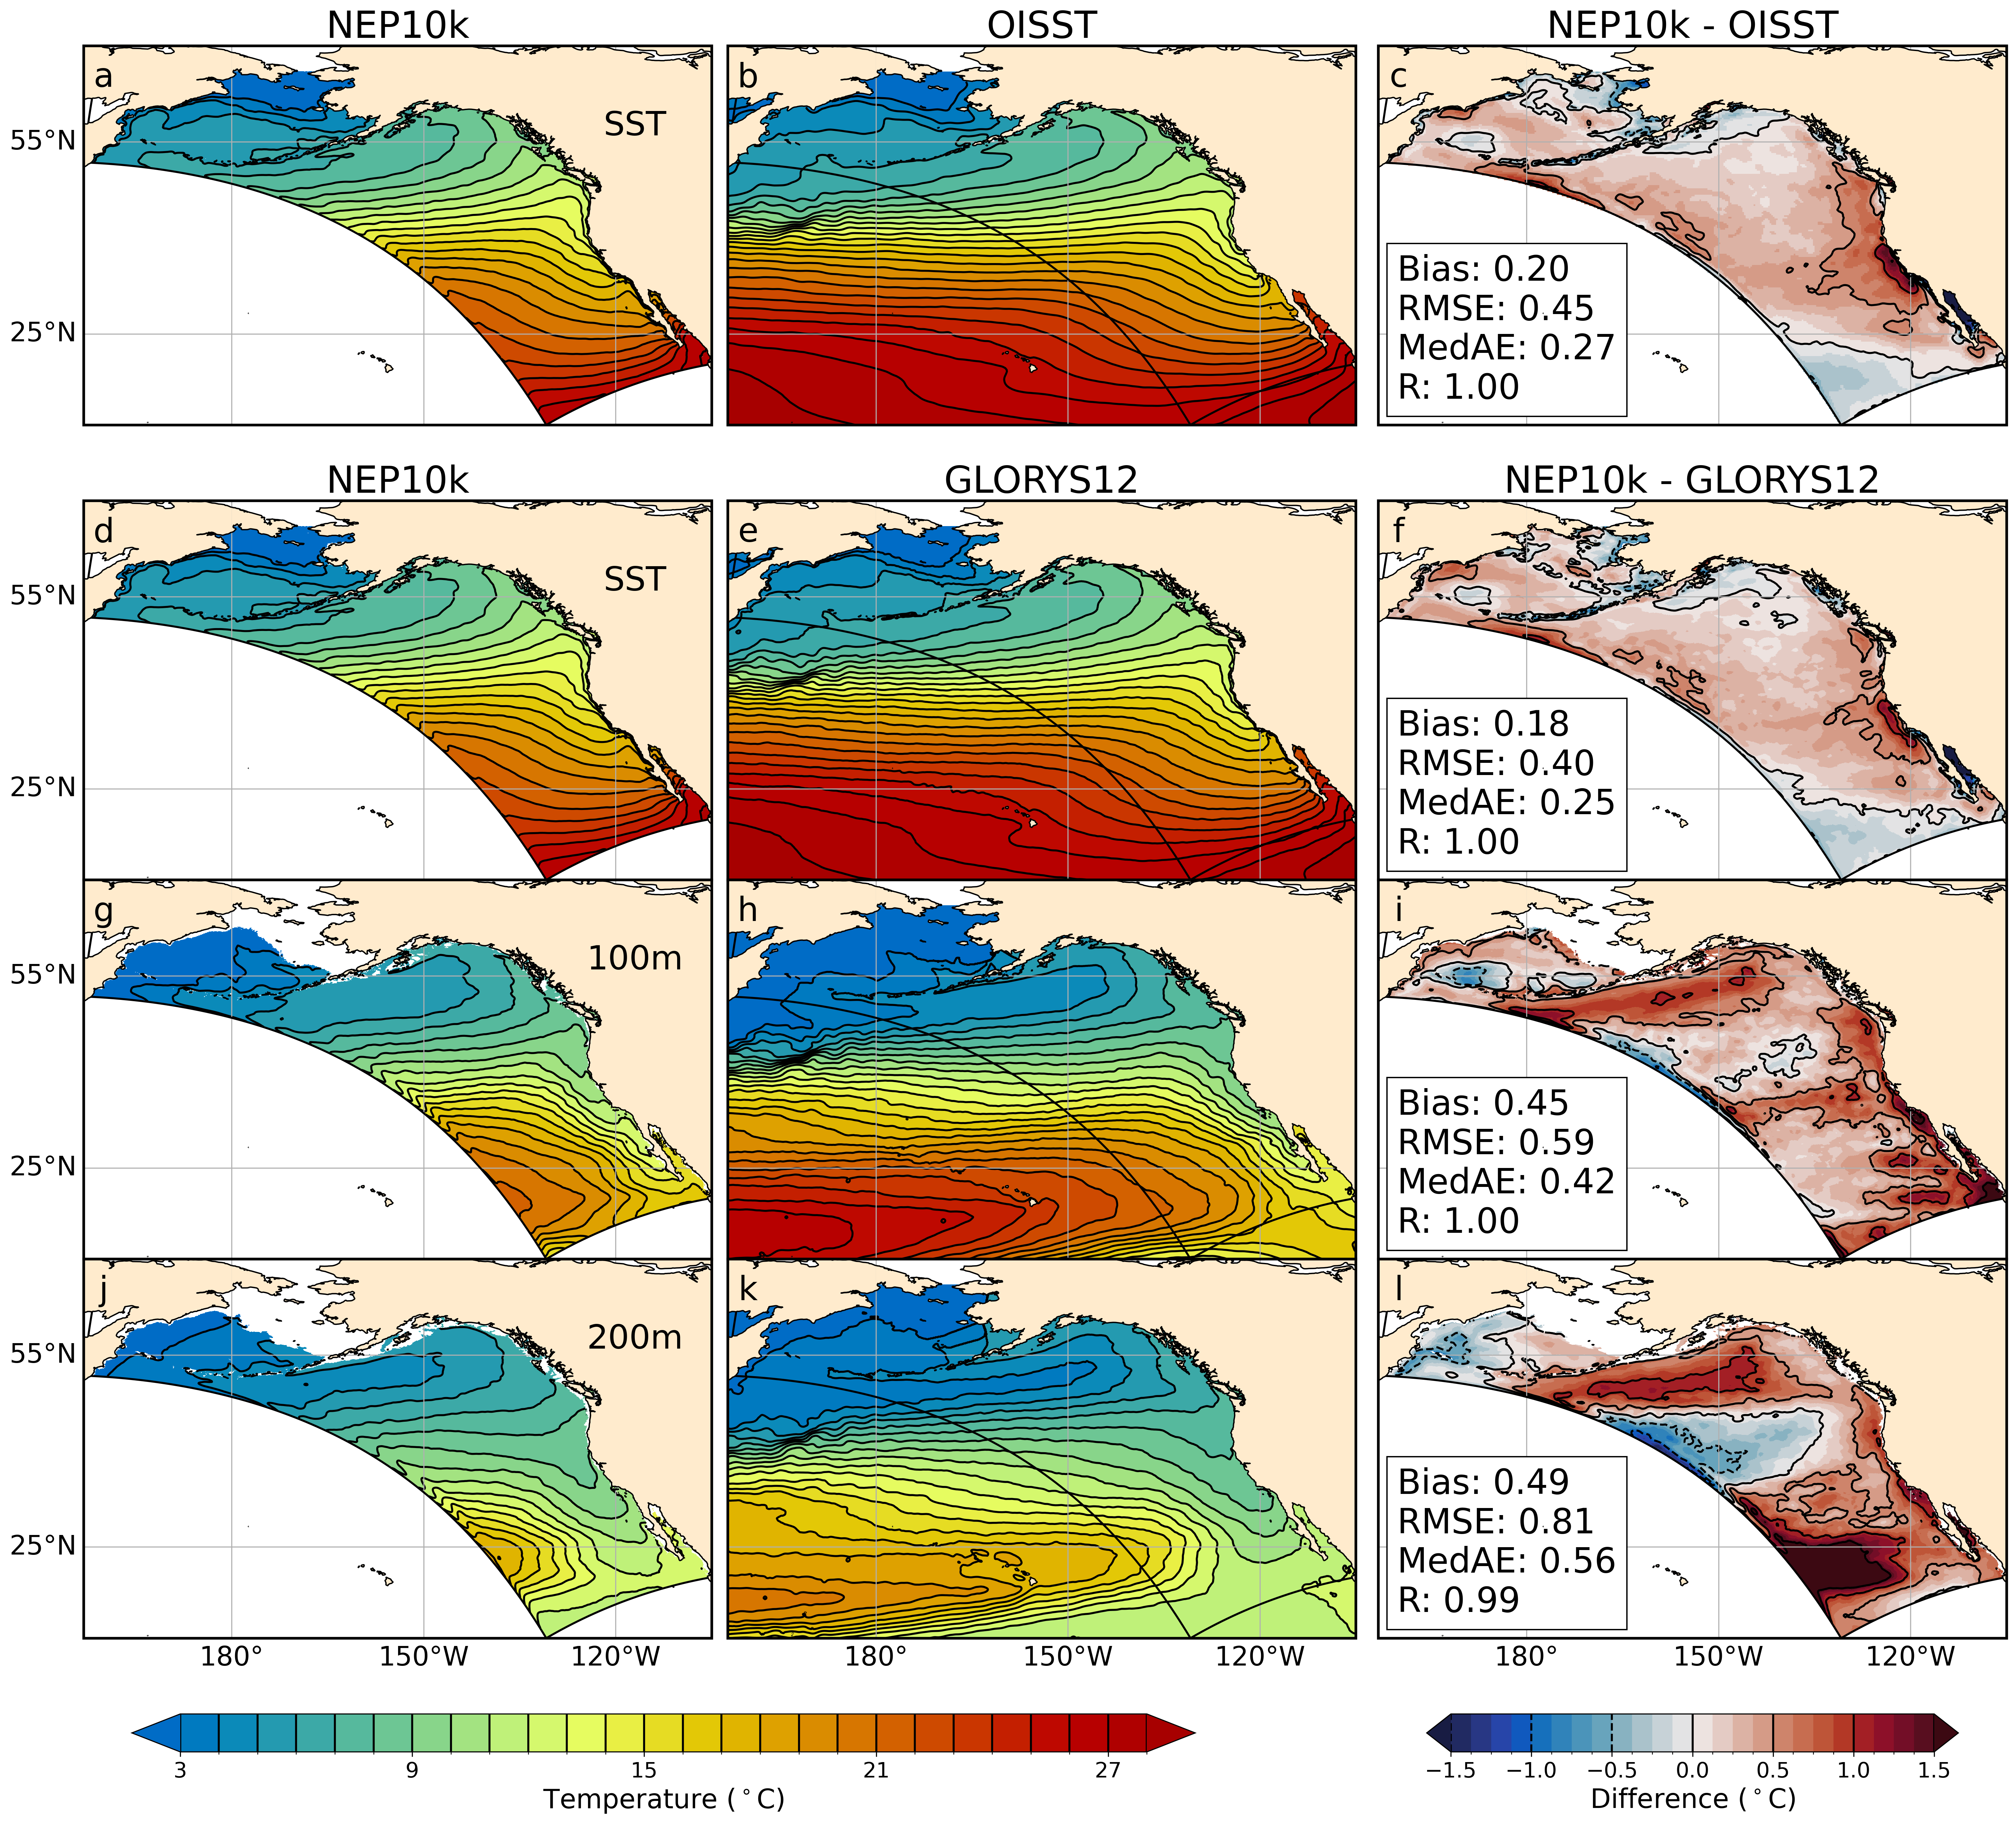

In [10]:
heights = [10,2,10,10,10,1]
widths = [10,10,.1,10]
stats_box_props = dict(boxstyle="square", fc="w", ec="0.0", alpha=1)     
print_stats = True
const_offset = 500

for season in ['mean']:
    fig = plt.figure(figsize=(26,22),dpi=300)
    spec = fig.add_gridspec(ncols=4, nrows=6,wspace=0,hspace=0.,height_ratios=heights, width_ratios=widths)  
    nrow = 0
    nlab = 0
    ds_nep = get_model_ds('NEP')
    
    for comp_mod in ['OISST','GLORYS12']:
    
        print(comp_mod)
    
        ds_comp = get_model_ds(comp_mod)
        lat,lon,clat,clon,chuk_mask = get_coords(comp_mod,ds_comp)        

        for dep in mod_dict[comp_mod]['depths']:
            ncol=0
            print(dep)

            # Interpolate depth values
            if comp_mod == 'OISST':
                dep_val = 0.
                comp_val = ds_comp[mod_dict[comp_mod]['temp_var']].values.squeeze()
                nep_val = ds_nep[mod_dict['NEP']['temp_var']].values[:,0,:].squeeze()

                # create regrid object: NEP -> OISST
                sourcefield, destfield, regrid = create_regrid_obj(nep_clon,nep_clat,lsm,clon,clat)
                
                # regrid NEP to OISST
                nt1,nj,ni = comp_val.shape
                nep_val_out = np.zeros((nt1,nj,ni))
                for nt in range(nt1):
                    sourcefield.data[...] = nep_val[nt,:].squeeze() + const_offset
                    destfield = regrid(sourcefield, destfield)
                    tmp_val = copy.deepcopy(destfield.data)
                    tmp_val[tmp_val==0] = np.nan
                    nep_val_out[nt,:] = tmp_val - const_offset   
                
                sourcefield.data[...] = lsm + const_offset
                destfield = regrid(sourcefield, destfield)
                tmp_val = copy.deepcopy(destfield.data)
                tmp_val[tmp_val==0] = np.nan
                lsm_out = tmp_val - const_offset
                lsm_out[lsm_out>.5]=1
                lsm_out[lsm_out<.5]=0 
                
                comp_diff_val = copy.deepcopy(comp_val)
                comp_diff_val = np.mean(comp_diff_val,axis=0)
                # remove chukchi sea
                comp_diff_val[chuk_mask] = np.nan
                # remove values outside NEP domain
                comp_diff_val[lsm_out==0] = np.nan
                
                nep_diff_val = copy.deepcopy(nep_val_out)
                nep_diff_val = np.mean(nep_diff_val,axis=0)
                # remove chukchi sea
                nep_diff_val[chuk_mask] = np.nan
                # remove values outside NEP domain
                nep_diff_val[lsm_out==0] = np.nan 
                
                # Get area for weighted statistics 
                sourcefield.data[...] = nep_area + const_offset
                destfield = regrid(sourcefield, destfield)
                tmp_val = copy.deepcopy(destfield.data)
                tmp_val[tmp_val==0] = np.nan
                area_out = tmp_val - const_offset
                dif_clon = clon; dif_clat = clat
                dif_lon = lon; dif_lat = lat
                
            else:

                comp_val = ds_comp[mod_dict[comp_mod]['temp_var']].interp(depth=depths[dep]['val']).values.squeeze()
                comp_lsm = ~np.isnan(comp_val[0,:].squeeze())
                nep_val = ds_nep[mod_dict['NEP']['temp_var']].interp(depth=depths[dep]['val']).values.squeeze()
                nep_val[0,nep_topo<=depths[dep]['val']] = np.nan
                
                # create regrid object: GLORYS -> NEP
                sourcefield, destfield, regrid = create_regrid_obj(clon,clat,comp_lsm,nep_clon,nep_clat)

                # regrid GLORYS to NEP
                nt1,nj,ni = nep_val.shape
                comp_val_out = np.zeros((nt1,nj,ni))
                for nt in range(nt1):
                        sourcefield.data[...] = comp_val[nt,:].squeeze() + const_offset
                        destfield = regrid(sourcefield, destfield)
                        tmp_val = copy.deepcopy(destfield.data)
                        tmp_val[tmp_val==0] = np.nan
                        comp_val_out[nt,:] = tmp_val - const_offset

                comp_diff_val = copy.deepcopy(comp_val_out)
                comp_diff_val = np.mean(comp_diff_val,axis=0)
                comp_diff_val[nep_lat>66] = np.nan
                comp_diff_val[lsm==0] = np.nan
                
                nep_diff_val = copy.deepcopy(nep_val)
                nep_diff_val = np.mean(nep_diff_val,axis=0)
                nep_diff_val[nep_lat>66] = np.nan
                nep_diff_val[lsm==0] = np.nan
                
                area_out = copy.deepcopy(nep_area)
                dif_clon = nep_clon; dif_clat = nep_clat
                dif_lon = nep_lon; dif_lat = nep_lat
                
            # PLOT NEP on native grid
            nep_val[:,nep_lat>66]=np.nan
            plot_map(nep_clon,nep_clat,nep_lon,nep_lat,np.mean(nep_val,axis=0),3,28,cmap1,norm1,1)
            ncol+=1
            nlab+=1
            
            # PLOT comparison product on its native grid
            comp_val[:,chuk_mask]=np.nan
            plot_map(clon,clat,lon,lat,np.mean(comp_val,axis=0),3,28,cmap1,norm1,1)
            ncol+=2
            nlab+=1

            # CALCULATE STATISTICS
            mean_bias, rmse, medae, corr = calc_stats(nep_diff_val,comp_diff_val,area_out)
            
            # PLOT difference (NEP - comparison product) on coarser grid
            plot_map(dif_clon,dif_clat,dif_lon,dif_lat,nep_diff_val-comp_diff_val,-1.5,1.5,cmap2,norm2,.5)
            nlab+=1
            
            if comp_mod == 'OISST':
                nrow+=2
            else:
                nrow+=1
                
    
    fig_file_name = f'/work/Utheri.Wagura/NEP/plotting/Figure_2/{experiment}/Figure2_NEP_vs_OISST-and-GLORYS_mean'
    
    plt.savefig(fig_file_name)